In [51]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [52]:
#   数据预处理
path_A='Accelerometer.csv'
path_G='Gyroscope.csv'
path_M='Magnetometer.csv'
path_L='Location.csv'

In [53]:
Data_A=pd.read_csv(path_A)
Data_G=pd.read_csv(path_G)
Data_M=pd.read_csv(path_M)
Data_L=pd.read_csv(path_L)
A=Data_A.iloc[1:,1:]
G=Data_G.iloc[:,1:]
M=Data_M.iloc[:,1:]
L=Data_L.iloc[:,1:3]
Time=Data_G.iloc[:,:1]
A=np.array(A)
G=np.array(G)
M=np.array(M)
L=np.array(L)
Time=np.array(Time).ravel()


In [54]:
#   step1  检测步数

w=15        #定义滑动窗口


A_p=np.sqrt(A[:,0]**2+A[:,1]**2+A[:,2]**2)
A_mean=np.zeros_like(A_p)
A_sigma=np.zeros_like(A_p)

#   计算平均值 
for k in range(len(A_mean)):
    if k>=w:
        A_mean[k]=np.sum(A_p[k-w:k+w+1])/(w*2+1)
    else:
        A_mean[k]=np.sum(A_p[k:k+w+1])/(w+1)

temp=(A_p-A_mean)**2
#   计算方差
for k in range(len(A_mean)):
    if k>=w:
        A_sigma[k]=np.sum(temp[k-w:k+w+1])/(w*2+1)
    else:
        A_sigma[k]=np.sum(temp[k:k+w+1])/(w+1)

del(temp)

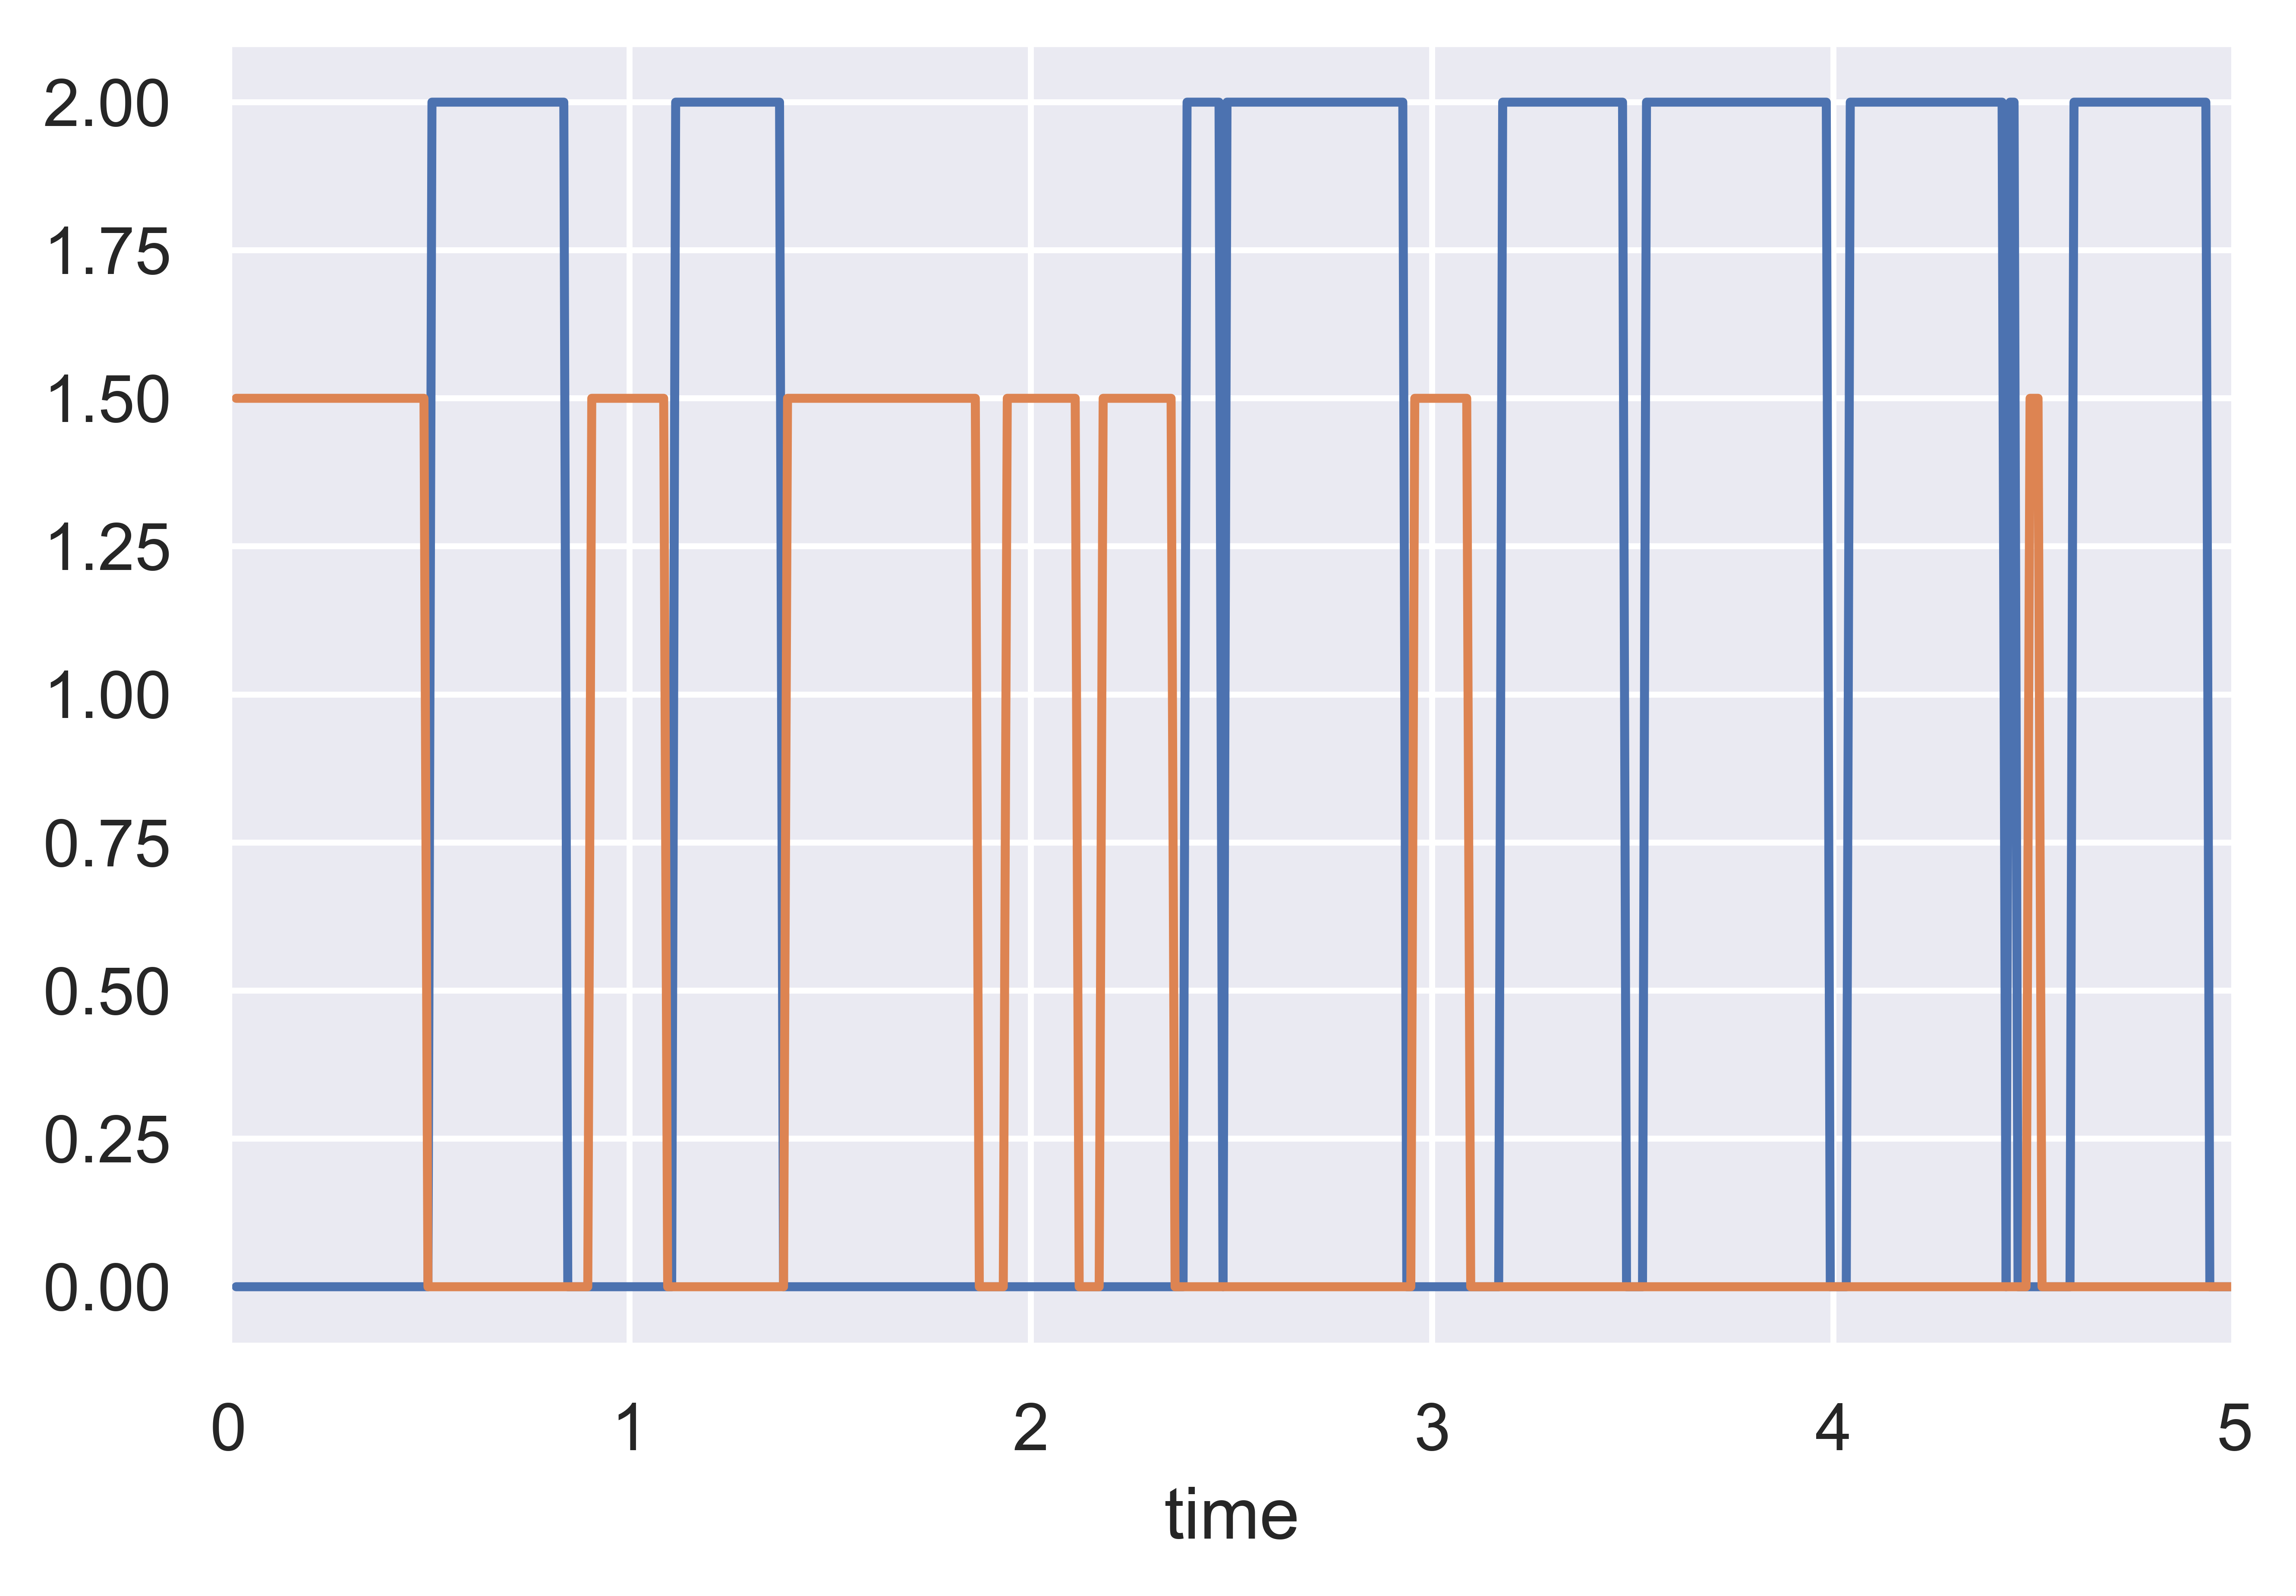

In [55]:
B1=np.zeros_like(A_p)
B2=np.zeros_like(A_p)
T1=2      #   第一阈值      步数受这两个阈值控制
T2=1.5    #   第二阈值

B1=np.where(A_sigma>T1,T1,0)
B2=np.where(A_sigma<T2,T2,0)
data={'time':Time,'b1':B1,'b2':B2}
step_data=pd.DataFrame(data)
#   画个图看看效果
sns.set()

plt.figure(dpi=1000)
plt.xlim((0,5))
# plt.plot(Time,B1,'b',lw=0.1)
# plt.plot(Time,B2,'r',lw=0.5)
# plt.xlabel('time(/s)')
# plt.ylabel('m/s^2')
sns.lineplot(x='time',y=B1,data=step_data)
sns.lineplot(x='time',y=B2,data=step_data)

plt.show()

In [56]:
#   计算步数
steps=np.zeros_like(A_p)
for k in range(len(A_p)-1):
    if B1[k]>B1[k+1] and max(B2[k:k+w+1])==T2:
        steps[k]=1


In [57]:
steps_n=np.sum(steps)
steps_n

116.0

In [58]:
#   SL算法(1) Weiberg SL Algorithm
SL=np.zeros(int(steps_n))

In [59]:
b,a=signal.butter(4,2*3/100)
A_lowpass=signal.filtfilt(b,a,A_p,axis=0)
condict=np.arange(0,len(A_p))[steps>0]
i=0
for k in range(len(condict)):
    SL[k]=pow((max(A_lowpass[condict[k]-w:condict[k]+w+1])-min(A_lowpass[condict[k]-w:condict[k]+w+1])),0.25)



In [60]:
#   SL算法(2) ZUPT Algorithm

In [61]:
#   2D position estimation
#   解算初始姿态角
g=9.80665
theta=np.arcsin(-A[0][0]/g)
gamma=np.arctan(A[0][1]/A[0][2])
#   计算姿态角  不含磁北与真北的磁偏角
angle=np.arctan(-(M[0][1]*np.cos(gamma)-M[0][2]*np.sin(gamma))/(M[0][0]*np.cos(theta)+M[0][1]*np.sin(theta)*np.sin(gamma)+M[0][2]*np.sin(theta)*np.cos(gamma)))




In [62]:
#   接下来每一步的姿态角通过角速度积分得到
phi=np.zeros(int(steps_n))
phi[0]=(np.sum(G[:condict[0],0])*0.01 + np.sum(G[:condict[0],1])*0.01)/2
for k in range(1,len(condict)):
    
    phi[k]=(np.sum(G[condict[k-1]:condict[k],0])*0.01 + np.sum(G[condict[k-1]:condict[k],1])*0.01)/2


In [63]:

position_n=np.sum(np.cos(phi)*SL)
position_e=np.sum(np.sin(phi)*SL)
print(position_n,'m')
print(position_e,'m')

171.1319906710801 m
-0.319979113365323 m


long2 = long1 + d*cosα/[ARC*cos(lat1)*2π/360]

lat2 = lat1 +d*sinα/ (ARC *2π/360)

α为相对磁北的航向角
# 此公式有待研究!!!!

In [64]:
ARC=6371.393*1000

#lat0=2.258762088E1 gps signal
#lon0=1.139664481E2
lat0=22.5871112
lon0=113.96687
print(lat0,lon0)
lat=np.zeros(len(phi)+1)
lon=np.zeros(len(phi)+1)
lat[0]=lat0
lon[0]=lon0
for k in range(1,len(phi)+1):
    lon[k]=lon[k-1]+SL[k-1]*np.cos(phi[k-1])/(ARC*np.cos(lat[k-1])*np.pi*2/360)
    lat[k]=lat[k-1]+SL[k-1]*np.sin(phi[k-1])/(ARC*np.pi*2/360)

lat1=lat[-1]
lon1=lon[-1]

lat1_gps=2.258769455E1
lon1_gps=1.139646897E2
print(lat1,lon1)
print(lat1_gps,lon1_gps)

22.5871112 113.96687
22.587108322536192 113.96501051095666
22.58769455 113.9646897


比起实验一,精度有明显的提升,


需要注意的是GPS信号不准确,导致最终计算的定位不准确.
但是将真实起点坐标输入后,可以得到较ex1更准确的终点坐标,说明算法是有效的